<a href="https://colab.research.google.com/github/PosgradoMNA/actividades-del-projecto-grupo26/blob/main/Reto/Notebook/CopySemana9_RETO_Entrega1_grupo26.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Actividad semana 9 - RETO**
# **Ciencia y analítica de datos**

## **Nombre del profesor:** Maria de la Paz Rico Fernandez

## **Nombre:** Yeison Fernando Villamil Franco, Diego Alberto Olarte Mira
## **Matrícula:** A01793803, A01794028
## **Fecha:** 16 de Noviembre/2022

---

# **AGUAS SUPERFICIALES EVALUACIÓN**

# **Carga de datos y librerías**

## Librerías

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd
import qeds
from shapely.geometry import Point
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, OrdinalEncoder
from ipywidgets import interact, interactive, fixed, interact_manual, Dropdown
import ipywidgets as widgets
from sklearn.cluster import KMeans
from yellowbrick.cluster import SilhouetteVisualizer, KElbowVisualizer
from sklearn.metrics import silhouette_score
import plotly.offline as py
from fiona.drvsupport import supported_drivers
from geopy.geocoders import Nominatim
import fiona
import plotly.graph_objs as go
from scipy import stats
pd.set_option('display.max_columns', 500)
import geopy.distance
%matplotlib inline
# activate plot theme

## Lectura del conjunto de datos

In [9]:
df_superficiales = pd.read_csv("https://raw.githubusercontent.com/PosgradoMNA/actividades-del-projecto-grupo26/main/Reto/data/Datos_de_calidad_del_agua_de_sitios_de_monitoreo_de_aguas_superficiales_2020.csv", encoding="latin-1" )

In [10]:
#Eliminar registros vacios que vienen al final del dataset
df_superficiales = df_superficiales.dropna(how="all")

In [11]:
df_superficiales.shape

(3493, 55)

## Valores Faltantes

In [12]:
null_cols = pd.DataFrame(len(df_superficiales['CLAVE']) - df_superficiales.isnull().sum(), columns = ['Count'])

trace = go.Bar(x = null_cols.index, y = null_cols['Count'] ,opacity = 0.8, marker=dict(color = 'lightgrey',
        line=dict(color='#000000',width=1.5)))

layout = dict(title =  "Distribución de datos en cada columna")
                    
fig = dict(data = [trace], layout=layout)
py.iplot(fig)

In [13]:
df_superficiales.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3493 entries, 0 to 3492
Data columns (total 55 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   CLAVE                   3493 non-null   object 
 1   SITIO                   3493 non-null   object 
 2   ORGANISMO_DE_CUENCA     3493 non-null   object 
 3   ESTADO                  3493 non-null   object 
 4   MUNICIPIO               3493 non-null   object 
 5   CUENCA                  3492 non-null   object 
 6   CUERPO DE AGUA          3479 non-null   object 
 7   TIPO                    3493 non-null   object 
 8   SUBTIPO                 3479 non-null   object 
 9   LONGITUD                3493 non-null   float64
 10  LATITUD                 3493 non-null   float64
 11  PERIODO                 3493 non-null   float64
 12  DBO_mg/L                2581 non-null   object 
 13  CALIDAD_DBO             2581 non-null   object 
 14  DQO_mg/L                2581 non-null   

`Se puede observar que:`

* Las columnas CUENCA,CUERPO DE AGUA, SUBTIPO tienen pocos valores nulos
* Las columnas TOX_D_48_FON_UT, CALIDAD_TOX_D_48_FON, TOX_FIS_FON_15_UT, CALIDAD_TOX_FIS_FON_15 tienen todos sus valores nulos
* Las columnas DBO_mg/L, CALIDAD_DBO, DQO_mg/L, CALIDAD_DQO, SST_mg/L, CALIDAD_SST, COLI_FEC_NMP_100mL, CALIDAD_COLI_FEC, E_COLI_NMP_100mL, CALIDAD_E_COLI, ENTEROC_NMP_100mL, CALIDAD_ENTEROC, OD_PORC, CALIDAD_OD_PORC, OD_PORC_SUP, CALIDAD_OD_PORC_SUP, OD_PORC_MED, CALIDAD_OD_PORC_MED, OD_PORC_FON, CALIDAD_OD_PORC_FON, TOX_D_48_UT, CALIDAD_TOX_D_48, TOX_V_15_UT, CALIDAD_TOX_V_15, TOX_D_48_SUP_UT, CALIDAD TOX_D_48_SUP, TOX_FIS_SUP_15_UT, CALIDAD_TOX_FIS_SUP_15 contienen valores Nulos
* La columna CONTAMINANTES contiene valores Nulos, sin embargo se debe a que este es un listado de contaminantes para cada observacion y si no se observan contaminantes debe quedar vacio

## Descartas features

In [14]:
df_superficiales.dropna(axis=1 , how="all", inplace=True)

## Ajustar tipo de datos

In [15]:
metric_cols = ['COLI_FEC_NMP_100mL','E_COLI_NMP_100mL','ENTEROC_NMP_100mL','OD_PORC','OD_PORC_FON','OD_PORC_MED','OD_PORC_SUP','SST_mg/L','TOX_D_48_SUP_UT','TOX_D_48_UT','TOX_FIS_SUP_15_UT','TOX_V_15_UT','DBO_mg/L','DQO_mg/L']

In [16]:
val_to_replace = {"<":""}
                  
for col in metric_cols:
    for key,value in val_to_replace.items():
        
        df_superficiales[col] = df_superficiales[col].fillna(np.nan).astype("str").str.replace(key,value).astype(float)

In [17]:
df_superficiales.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3493 entries, 0 to 3492
Data columns (total 51 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   CLAVE                   3493 non-null   object 
 1   SITIO                   3493 non-null   object 
 2   ORGANISMO_DE_CUENCA     3493 non-null   object 
 3   ESTADO                  3493 non-null   object 
 4   MUNICIPIO               3493 non-null   object 
 5   CUENCA                  3492 non-null   object 
 6   CUERPO DE AGUA          3479 non-null   object 
 7   TIPO                    3493 non-null   object 
 8   SUBTIPO                 3479 non-null   object 
 9   LONGITUD                3493 non-null   float64
 10  LATITUD                 3493 non-null   float64
 11  PERIODO                 3493 non-null   float64
 12  DBO_mg/L                2581 non-null   float64
 13  CALIDAD_DBO             2581 non-null   object 
 14  DQO_mg/L                2581 non-null   

# Exploratory data analysis**

Para las columnas de medidas numericas que se tienen valores nulos se podria reemplazar estos valores con la media de sus respectivas columnas, o con la el promedio con respecto al tipo de contaminacion, sin embargo de acuerdo al estudio del negocio consideramos que no es adecuado imputar valores en las medidas que no fueron registradas, ya que posiblemente el negocio no realizo las pruebas para dichas metricas y el hecho de imputar un valor puede afectar el diagnostico de la clase en el semaforo


In [18]:
df_superficiales.head(2)

,CLAVE,SITIO,ORGANISMO_DE_CUENCA,ESTADO,MUNICIPIO,CUENCA,CUERPO DE AGUA,TIPO,SUBTIPO,LONGITUD,LATITUD,PERIODO,DBO_mg/L,CALIDAD_DBO,DQO_mg/L,CALIDAD_DQO,SST_mg/L,CALIDAD_SST,COLI_FEC_NMP_100mL,CALIDAD_COLI_FEC,E_COLI_NMP_100mL,CALIDAD_E_COLI,ENTEROC_NMP_100mL,CALIDAD_ENTEROC,OD_PORC,CALIDAD_OD_PORC,OD_PORC_SUP,CALIDAD_OD_PORC_SUP,OD_PORC_MED,CALIDAD_OD_PORC_MED,OD_PORC_FON,CALIDAD_OD_PORC_FON,TOX_D_48_UT,CALIDAD_TOX_D_48,TOX_V_15_UT,CALIDAD_TOX_V_15,TOX_D_48_SUP_UT,CALIDAD TOX_D_48_SUP,TOX_FIS_SUP_15_UT,CALIDAD_TOX_FIS_SUP_15,SEMAFORO,CONTAMINANTES,CUMPLE_CON_DBO,CUMPLE_CON_DQO,CUMPLE_CON_SST,CUMPLE_CON_CF,CUMPLE_CON_E_COLI,CUMPLE_CON_ENTEROC,CUMPLE_CON_OD,CUMPLE_CON_TOX,GRUPO
0,DLAGU8,PRESA EL SAUCILLO 100M AGUAS ARRIBA DE LA CORTINA,LERMA SANTIAGO PACIFICO,AGUASCALIENTES,RINCON DE ROMOS,RIO SAN PEDRO,PRESA EL SAUCILLO,LENTICO,PRESA,-102.33911,22.24730,2020.0,6.0,Buena calidad,54.08,Contaminada,13.75,Excelente,1162.0,Contaminada,98.0,Excelente,NaN,NaN,NaN,NaN,46.8,Aceptable,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,No Toxico,1.0,No Toxico,Rojo,"DQO,CF,",SI,NO,SI,NO,SI,ND,SI,SI,LENTICO
1,DLBAJ100,"LOS CABOS SEG 22, 2 ISA10B",PENINSULA DE BAJA CALIFORNIA,BAJA CALIFORNIA SUR,LOS CABOS,SAN JOSE DEL CABO,OCEANO PACIFICO,COSTERO,OCEANO-MAR,-109.84290,22.90473,2020.0,NaN,NaN,NaN,NaN,10.00,Excelente,NaN,NaN,NaN,NaN,20.0,Excelente,NaN,NaN,92.0,Excelente,95.4,Excelente,92.2,Excelente,NaN,NaN,NaN,NaN,NaN,NaN,1.0,No Toxico,Verde,NaN,ND,ND,SI,ND,ND,SI,SI,SI,COSTERO


In [19]:
df_superficiales.describe()

,LONGITUD,LATITUD,PERIODO,DBO_mg/L,DQO_mg/L,SST_mg/L,COLI_FEC_NMP_100mL,E_COLI_NMP_100mL,ENTEROC_NMP_100mL,OD_PORC,OD_PORC_SUP,OD_PORC_MED,OD_PORC_FON,TOX_D_48_UT,TOX_V_15_UT,TOX_D_48_SUP_UT,TOX_FIS_SUP_15_UT
count,3493.000000,3493.000000,3493.0,2581.000000,2581.000000,3489.000000,2.582000e+03,2.582000e+03,904.000000,1797.000000,1619.000000,487.000000,946.000000,1816.000000,1819.000000,762.000000,1674.000000
mean,-100.359969,21.046992,2020.0,16.886481,64.332985,102.148144,9.568881e+04,7.933769e+04,1086.709845,66.840289,81.459975,71.590965,66.869239,1.061622,1.795665,1.054646,1.024892
std,6.122773,3.893696,0.0,65.140268,149.828058,441.860401,1.168887e+06,1.051334e+06,4305.913327,31.417153,28.562290,26.370102,28.197108,0.652352,6.326818,0.867567,0.319834
min,-117.124030,14.534910,2020.0,2.000000,10.000000,10.000000,3.000000e+00,3.000000e+00,3.000000,10.000000,10.000000,10.000000,10.000000,1.000000,1.000000,1.000000,1.000000
25%,-103.882310,18.396070,2020.0,2.000000,11.870000,10.000000,3.420000e+02,4.000000e+01,3.000000,44.300000,61.200000,52.400000,47.325000,1.000000,1.000000,1.000000,1.000000
50%,-99.795530,20.148980,2020.0,2.630000,27.010000,24.300000,2.400000e+03,4.240000e+02,3.000000,68.300000,84.100000,72.400000,67.500000,1.000000,1.000000,1.000000,1.000000
75%,-96.860230,22.828930,2020.0,10.000000,57.000000,57.000000,2.400000e+04,6.488000e+03,63.000000,91.600000,99.950000,91.500000,88.875000,1.000000,1.000000,1.000000,1.000000
max,-86.732150,32.706500,2020.0,1500.000000,2871.250000,9430.000000,2.419600e+07,2.419600e+07,24196.000000,226.100000,289.000000,133.000000,146.000000,23.949000,156.250000,21.320000,7.870000


## Distribución de la variable objetivo

Validar el numero de valores para cada clase en SEMAFORO

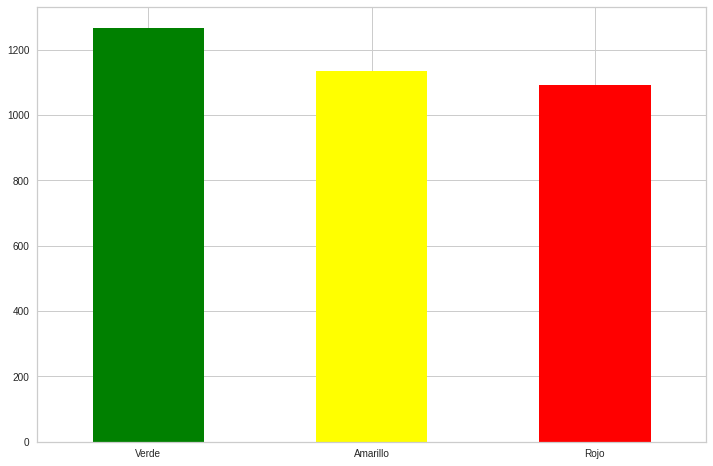

In [20]:
plt.rcParams['figure.figsize'] = [12, 8]
df_superficiales['SEMAFORO'].value_counts().plot(kind='bar', color=['green', 'yellow', 'red'])
plt.xticks(rotation=0)
plt.show()

## Distribución de las features numéricas

In [21]:
for col in metric_cols:
    print(col,'\n\nVerde:\n\n',df_superficiales[df_superficiales["SEMAFORO"]=="Verde"][col].describe(),'\n\nAmarillo:\n\n',df_superficiales[df_superficiales["SEMAFORO"]=="Amarillo"][col].describe(),'\n\nRojo:\n\n',df_superficiales[df_superficiales["SEMAFORO"]=="Rojo"][col].describe(),end='\n\n')

COLI_FEC_NMP_100mL 

Verde:

 count    544.000000
mean     281.205882
std      276.242590
min        3.000000
25%       41.000000
50%      210.000000
75%      430.000000
max      991.000000
Name: COLI_FEC_NMP_100mL, dtype: float64 

Amarillo:

 count      1100.000000
mean      12109.446364
std       25081.166681
min           3.000000
25%        1793.000000
50%        3873.000000
75%       24000.000000
max      241960.000000
Name: COLI_FEC_NMP_100mL, dtype: float64 

Rojo:

 count    9.380000e+02
mean     2.490353e+05
std      1.930221e+06
min      3.000000e+00
25%      4.300000e+02
50%      1.100000e+04
75%      2.400000e+04
max      2.419600e+07
Name: COLI_FEC_NMP_100mL, dtype: float64

E_COLI_NMP_100mL 

Verde:

 count    544.000000
mean      91.069853
std      135.977177
min        3.000000
25%        3.000000
50%       29.000000
75%      124.000000
max      750.000000
Name: E_COLI_NMP_100mL, dtype: float64 

Amarillo:

 count      1100.000000
mean       6901.537273
std       19801

* Vemos que para cada metrica hay cambios en la media de acuerdo a su diagnostico de contaminacion.

Validar diferencias de cada feature con respecto a su valor en el semaforo

In [22]:
def function_map(metrica = "OD_PORC_FON"):
    sns.color_palette("husl", 9)
    sns.set_theme(style='whitegrid')
    plt.title(metrica)
    sns.kdeplot(x=df_superficiales[metrica],hue = df_superficiales['SEMAFORO'], palette={"Rojo":"red","Verde":"green","Amarillo":"orange"} )
    plt.tight_layout()
    plt.show()

In [23]:
interact(function_map, metrica=metric_cols)

interactive(children=(Dropdown(description='metrica', index=4, options=('COLI_FEC_NMP_100mL', 'E_COLI_NMP_100m…

<function __main__.function_map(metrica='OD_PORC_FON')>

## Matriz de correlación

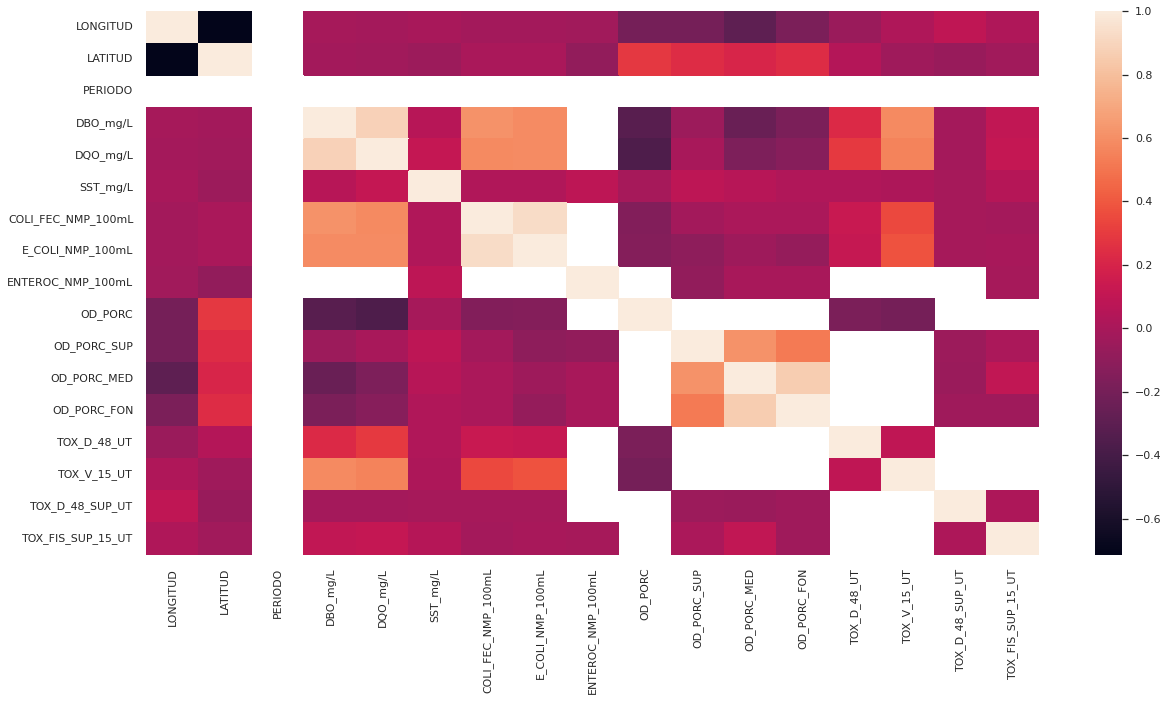

In [24]:
plt.rcParams['figure.figsize'] = [20, 10]
sns.heatmap(df_superficiales.corr())

## Identificar medidas de posición no centrales , los cuartiles , outliers

In [25]:
def function_map(metrica='OD_PORC_FON'):

    fig,ax = plt.subplots(1,4,figsize=(20,5))
    
    sns.histplot(data=df_superficiales, x=metrica,ax=ax[0],color='green', kde=True)
    sns.boxplot(data=df_superficiales, x=metrica,ax=ax[1],color='yellow')
    sns.violinplot(data=df_superficiales, x=metrica,ax=ax[2],color='purple')
    stats.probplot(df_superficiales[metrica],plot=ax[3])

    fig.tight_layout()
    fig.subplots_adjust(top=0.90)
    plt.suptitle("Visualizando columnas continuas",fontsize=25)

In [26]:
interact(function_map, metrica=metric_cols)

interactive(children=(Dropdown(description='metrica', index=4, options=('COLI_FEC_NMP_100mL', 'E_COLI_NMP_100m…

<function __main__.function_map(metrica='OD_PORC_FON')>

# **Preparar los datos**

## Label encoding

Identificar variables categoricas para transformar a label encoding

* Para la codificación de los datos se deben mencionar dos puntos importantes:
    * 1. Debido a que la medición puede verse representada en la categorización que es asignada a cada observación en cada una de las calidades, es importante solo considerar estas variables categóricas para codificar ya que son la representación también de la evaluación para dar la categoría del `SEMAFORO`.
    * 2. En la imputación, para las medidas no es necesario realizar este proceso ya que si existen un valor nulo no es porque hizo falta una medición. Esto se debe porque no fue realizada esta medición y los afluentes tienen pruebas de labotario específicas.

In [27]:
categ_cols = [col for col in df_superficiales if col.startswith('CALIDAD')]
df_superficiales[categ_cols]

,CALIDAD_DBO,CALIDAD_DQO,CALIDAD_SST,CALIDAD_COLI_FEC,CALIDAD_E_COLI,CALIDAD_ENTEROC,CALIDAD_OD_PORC,CALIDAD_OD_PORC_SUP,CALIDAD_OD_PORC_MED,CALIDAD_OD_PORC_FON,CALIDAD_TOX_D_48,CALIDAD_TOX_V_15,CALIDAD TOX_D_48_SUP,CALIDAD_TOX_FIS_SUP_15
0,Buena calidad,Contaminada,Excelente,Contaminada,Excelente,NaN,NaN,Aceptable,NaN,NaN,NaN,NaN,No Toxico,No Toxico
1,NaN,NaN,Excelente,NaN,NaN,Excelente,NaN,Excelente,Excelente,Excelente,NaN,NaN,NaN,No Toxico
2,NaN,NaN,Excelente,NaN,NaN,Excelente,NaN,Excelente,Excelente,Excelente,NaN,NaN,NaN,No Toxico
3,NaN,NaN,Excelente,NaN,NaN,Excelente,NaN,NaN,NaN,Excelente,NaN,NaN,NaN,No Toxico
4,NaN,NaN,Excelente,NaN,NaN,Excelente,NaN,Excelente,Excelente,Excelente,NaN,NaN,NaN,No Toxico
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3488,Excelente,Excelente,Aceptable,Contaminada,Fuertemente contaminada,NaN,Buena calidad,NaN,NaN,NaN,No Toxico,No Toxico,NaN,NaN
3489,Contaminada,Contaminada,Buena calidad,Contaminada,Excelente,NaN,NaN,Excelente,NaN,NaN,NaN,NaN,No Toxico,No Toxico
3490,Buena calidad,Contaminada,Buena calidad,Aceptable,Excelente,NaN,Excelente,NaN,NaN,NaN,No Toxico,No Toxico,NaN,NaN
3491,Excelente,Aceptable,Buena calidad,Contaminada,Excelente,NaN,Excelente,NaN,NaN,NaN,No Toxico,No Toxico,NaN,NaN


In [28]:
encoder = LabelEncoder()
for col in categ_cols:
    df_superficiales[col] = encoder.fit_transform(df_superficiales[col])

In [29]:
df_superficiales[categ_cols]

,CALIDAD_DBO,CALIDAD_DQO,CALIDAD_SST,CALIDAD_COLI_FEC,CALIDAD_E_COLI,CALIDAD_ENTEROC,CALIDAD_OD_PORC,CALIDAD_OD_PORC_SUP,CALIDAD_OD_PORC_MED,CALIDAD_OD_PORC_FON,CALIDAD_TOX_D_48,CALIDAD_TOX_V_15,CALIDAD TOX_D_48_SUP,CALIDAD_TOX_FIS_SUP_15
0,1,2,3,2,3,4,5,0,5,5,4,4,0,0
1,5,5,3,5,5,2,5,3,3,3,4,4,4,0
2,5,5,3,5,5,2,5,3,3,3,4,4,4,0
3,5,5,3,5,5,2,5,5,5,3,4,4,4,0
4,5,5,3,5,5,2,5,3,3,3,4,4,4,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3488,3,3,0,2,4,4,1,5,5,5,0,0,4,4
3489,2,2,1,2,3,4,5,3,5,5,4,4,0,0
3490,1,2,1,0,3,4,3,5,5,5,0,0,4,4
3491,3,0,1,2,3,4,3,5,5,5,0,0,4,4


# **Mapa de México**

## Grafica latitud - longitud

In [30]:
supported_drivers['LIBKML'] = 'rw'
fiona.drvsupport.supported_drivers['KML'] = 'rw'
df = gpd.read_file('https://raw.githubusercontent.com/PosgradoMNA/actividades-del-projecto-grupo26/main/Reto/data/doc.kml', driver='LIBKML')

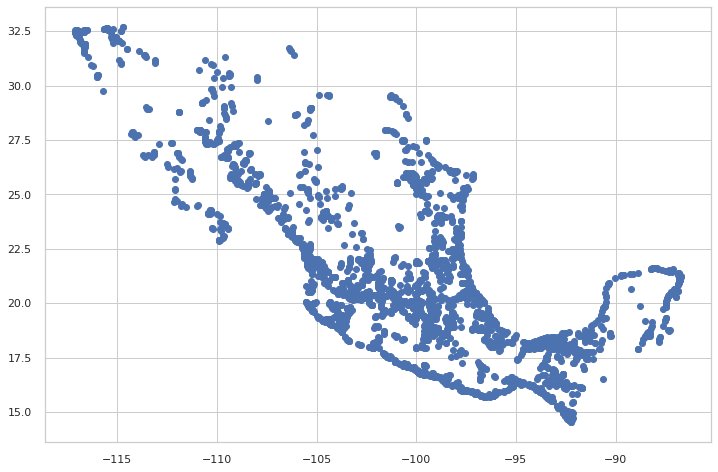

In [31]:
fig, axs = plt.subplots(figsize=(12, 8))
df.plot(ax=axs)

# **KMEANS**

## Realizar análisis para encontrar si existe una relación entre la calidad del agua y su ubicación geográfica a través de K- means.

In [32]:
df = pd.read_csv('https://raw.githubusercontent.com/PosgradoMNA/actividades-del-projecto-grupo26/main/Reto/data/Datos_de_calidad_del_agua_de_sitios_de_monitoreo_de_aguas_superficiales_2020.csv', encoding='latin-1', sep=',')

In [33]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4141 entries, 0 to 4140
Data columns (total 55 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   CLAVE                   3493 non-null   object 
 1   SITIO                   3493 non-null   object 
 2   ORGANISMO_DE_CUENCA     3493 non-null   object 
 3   ESTADO                  3493 non-null   object 
 4   MUNICIPIO               3493 non-null   object 
 5   CUENCA                  3492 non-null   object 
 6   CUERPO DE AGUA          3479 non-null   object 
 7   TIPO                    3493 non-null   object 
 8   SUBTIPO                 3479 non-null   object 
 9   LONGITUD                3493 non-null   float64
 10  LATITUD                 3493 non-null   float64
 11  PERIODO                 3493 non-null   float64
 12  DBO_mg/L                2581 non-null   object 
 13  CALIDAD_DBO             2581 non-null   object 
 14  DQO_mg/L                2581 non-null   

### **Información a destacar conjuntos de detos**

* Si consideramos que cada una de las evaluaciones de calidad de agua es a partir de una prueba de laboratorio específica, se evidencia que existen dos `CALIDAD_TOX_D_48_FON` y `CALIDAD_TOX_FIS_FON_15` que no poseen ningún valor. Por esto eliminamos las columnas para quedarnos con aquellas que poseen un valor.
* Adicionalmente se evidencia que para algunas evaluaciones de calidad, no contiene los `3493` registros completos. Sin embargo, no necesariamente se requiera de imputaciones específicas ya que estos puede ocurrir por lo siguiente:
    * En análisis de agua en afluentes específicos no siempre se realizan todas las pruebas de laboratorio, ya que estas se pueden relaciones por cuencas o afluentes específicamente. Es por esto que durante la revisión de los datos no se encuentran valores para algunas y es debido a que posiblemente no se realizó la prueba de laboratorio.
    * Para este tipo de calidad, la imputación fija que se puede plantear antes de realizar una imputación solo siguiendo metodología. Se tendrá que imputar como un `NA` o `No aplica` ya que esta prueba de laboratorio no fue realizada. Con esto en mente, como a partir de la medición se tiene un valor de calidad o una descripción de esta, si pensamos a nivel de modelamiento solo usaríamos la descripción ya que si tratamos de imputar las medidas propias, podemos afectar no solo la evaluación de las calidad, también la evaluación de la variables `SEMAFORO` ya qu esta depende directamente de todas las calidades evaluadas.


### **Segmentación**

* Para la parte de la segmentación, se realizará primero una visualización de las 14 calidades principales medidas para aguas superficiales, evidenciar el conteo y cuales son las descripciones que se le dan a cada una de estas y una visualización interactiva donde se contempla tener el mapa de México con las marcaciones para cada punto de latitud y longitud el semáforo y adicionalmente, la forma de cada punto lo dara la evaluación puntual de la cada una de las calidades.
* Es importante mencionar que para el punto anterior, se considera la librería `ipywidgets` ya que con esta es posible tener gráficos interactivos de cualquier tipo y para este caso tenemos un desplegable que permiten ver el comportamiento de la evaluación de calidad con cada `SEMAFORO` puntual indicado.
* Debido a que no se encontró una relación clara en la calidad y su ubicación geográfica si solo segmentamos latitud y longitud, ya que esta solo buscará centroídes más cercanos y dejará solo punto en `Norte`,`Centro` y `Sur`, se decide usar también la variable `Calidad_` y adicional a esto considerar la cuenca. El por qué de la cuenca: 
    * `RTA` --> Las cuencas a nivel de afluentes como ríos, quebradas entre otros son sistemas de drenaje natural donde se relacionen por ejemplo ríos específicos que pueden pasar por varios lugares. Con esto en mente, es posible encontrar algún contaminante para nacimiento en cuencas específicas que muestra relación alguna para las `Calidades` y la variables `SEMAFORO` 

In [34]:
col_to_drop = ['CALIDAD_TOX_FIS_FON_15', 'TOX_FIS_FON_15_UT', 'CALIDAD_TOX_D_48_FON', 'TOX_D_48_FON_UT']
df_drop = df.drop(columns=col_to_drop)
df_drop.head()

,CLAVE,SITIO,ORGANISMO_DE_CUENCA,ESTADO,MUNICIPIO,CUENCA,CUERPO DE AGUA,TIPO,SUBTIPO,LONGITUD,LATITUD,PERIODO,DBO_mg/L,CALIDAD_DBO,DQO_mg/L,CALIDAD_DQO,SST_mg/L,CALIDAD_SST,COLI_FEC_NMP_100mL,CALIDAD_COLI_FEC,E_COLI_NMP_100mL,CALIDAD_E_COLI,ENTEROC_NMP_100mL,CALIDAD_ENTEROC,OD_PORC,CALIDAD_OD_PORC,OD_PORC_SUP,CALIDAD_OD_PORC_SUP,OD_PORC_MED,CALIDAD_OD_PORC_MED,OD_PORC_FON,CALIDAD_OD_PORC_FON,TOX_D_48_UT,CALIDAD_TOX_D_48,TOX_V_15_UT,CALIDAD_TOX_V_15,TOX_D_48_SUP_UT,CALIDAD TOX_D_48_SUP,TOX_FIS_SUP_15_UT,CALIDAD_TOX_FIS_SUP_15,SEMAFORO,CONTAMINANTES,CUMPLE_CON_DBO,CUMPLE_CON_DQO,CUMPLE_CON_SST,CUMPLE_CON_CF,CUMPLE_CON_E_COLI,CUMPLE_CON_ENTEROC,CUMPLE_CON_OD,CUMPLE_CON_TOX,GRUPO
0,DLAGU8,PRESA EL SAUCILLO 100M AGUAS ARRIBA DE LA CORTINA,LERMA SANTIAGO PACIFICO,AGUASCALIENTES,RINCON DE ROMOS,RIO SAN PEDRO,PRESA EL SAUCILLO,LENTICO,PRESA,-102.33911,22.24730,2020.0,6,Buena calidad,54.08,Contaminada,13.75,Excelente,1162,Contaminada,98,Excelente,NaN,NaN,NaN,NaN,46.8,Aceptable,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,<1,No Toxico,<1,No Toxico,Rojo,"DQO,CF,",SI,NO,SI,NO,SI,ND,SI,SI,LENTICO
1,DLBAJ100,"LOS CABOS SEG 22, 2 ISA10B",PENINSULA DE BAJA CALIFORNIA,BAJA CALIFORNIA SUR,LOS CABOS,SAN JOSE DEL CABO,OCEANO PACIFICO,COSTERO,OCEANO-MAR,-109.84290,22.90473,2020.0,NaN,NaN,NaN,NaN,<10,Excelente,NaN,NaN,NaN,NaN,20,Excelente,NaN,NaN,92,Excelente,95.4,Excelente,92.2,Excelente,NaN,NaN,NaN,NaN,NaN,NaN,<1,No Toxico,Verde,NaN,ND,ND,SI,ND,ND,SI,SI,SI,COSTERO
2,DLBAJ101,"LOS CABOS SEG 22, 1 ISA10B",PENINSULA DE BAJA CALIFORNIA,BAJA CALIFORNIA SUR,LOS CABOS,SAN LUCAS,OCEANO PACIFICO,COSTERO,OCEANO-MAR,-109.86442,22.89880,2020.0,NaN,NaN,NaN,NaN,<10,Excelente,NaN,NaN,NaN,NaN,<3,Excelente,NaN,NaN,92,Excelente,95.4,Excelente,92.2,Excelente,NaN,NaN,NaN,NaN,NaN,NaN,<1,No Toxico,Verde,NaN,ND,ND,SI,ND,ND,SI,SI,SI,COSTERO
3,DLBAJ102,LOS CABOS 3,PENINSULA DE BAJA CALIFORNIA,BAJA CALIFORNIA SUR,LOS CABOS,SAN LUCAS,BAHIA SAN LUCAS,COSTERO,BAHIA,-109.88604,22.89609,2020.0,NaN,NaN,NaN,NaN,13.9667,Excelente,NaN,NaN,NaN,NaN,<3,Excelente,NaN,NaN,NaN,NaN,NaN,NaN,86.7,Excelente,NaN,NaN,NaN,NaN,NaN,NaN,<1,No Toxico,Verde,NaN,ND,ND,SI,ND,ND,SI,SI,SI,COSTERO
4,DLBAJ103,LOS CABOS 1,PENINSULA DE BAJA CALIFORNIA,BAJA CALIFORNIA SUR,LOS CABOS,SAN LUCAS,BAHIA SAN LUCAS,COSTERO,BAHIA,-109.89657,22.87694,2020.0,NaN,NaN,NaN,NaN,<10,Excelente,NaN,NaN,NaN,NaN,30,Excelente,NaN,NaN,96.2,Excelente,95.9,Excelente,95.5,Excelente,NaN,NaN,NaN,NaN,NaN,NaN,<1,No Toxico,Verde,NaN,ND,ND,SI,ND,ND,SI,SI,SI,COSTERO


Como fue mencionado arriba, solo nos quedaremos con las `Calidades` evaluadas para cada observación, esto permitirá poder tener una mejor visualización de que a pesar que la variable `SEMAFORO` tenga un valor `ROJO`, no necesariamente calidades específicas son malas. Así que depende no solo de las otras calidades evaludas, también de alguna ecuación de negocio que hace que todas caigan es esta categoría.

In [35]:
colunms_waterQA = [col for col in df_drop if col.startswith('CALIDAD')]
datos_plot = df_drop[colunms_waterQA].reset_index(drop=True)
datos_plot.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4141 entries, 0 to 4140
Data columns (total 14 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   CALIDAD_DBO             2581 non-null   object
 1   CALIDAD_DQO             2581 non-null   object
 2   CALIDAD_SST             3489 non-null   object
 3   CALIDAD_COLI_FEC        2582 non-null   object
 4   CALIDAD_E_COLI          2582 non-null   object
 5   CALIDAD_ENTEROC         904 non-null    object
 6   CALIDAD_OD_PORC         1797 non-null   object
 7   CALIDAD_OD_PORC_SUP     1619 non-null   object
 8   CALIDAD_OD_PORC_MED     487 non-null    object
 9   CALIDAD_OD_PORC_FON     946 non-null    object
 10  CALIDAD_TOX_D_48        1816 non-null   object
 11  CALIDAD_TOX_V_15        1819 non-null   object
 12  CALIDAD TOX_D_48_SUP    762 non-null    object
 13  CALIDAD_TOX_FIS_SUP_15  1674 non-null   object
dtypes: object(14)
memory usage: 453.0+ KB


Se observa que para muchas de las calidades de agua no se cuenta con un valor en su descripción. Esto es posible a que no todas las mediciones se realizaron para estos puntos específicos y por esto no se tiene un valor claro. Sin embargo, si existe una medición para algún tipo de contaminante e independiente de tener pocos valores, estos deben ser considerados

In [36]:
df_drop['SEMAFORO'].value_counts()

Verde       1267
Amarillo    1135
Rojo        1091
Name: SEMAFORO, dtype: int64

### Gráficos para calidades del agua

Se tiene una descripción visual del conteo de cada categoría de las calidades (14 en total) sin considerar la variable `SEMAFORO`

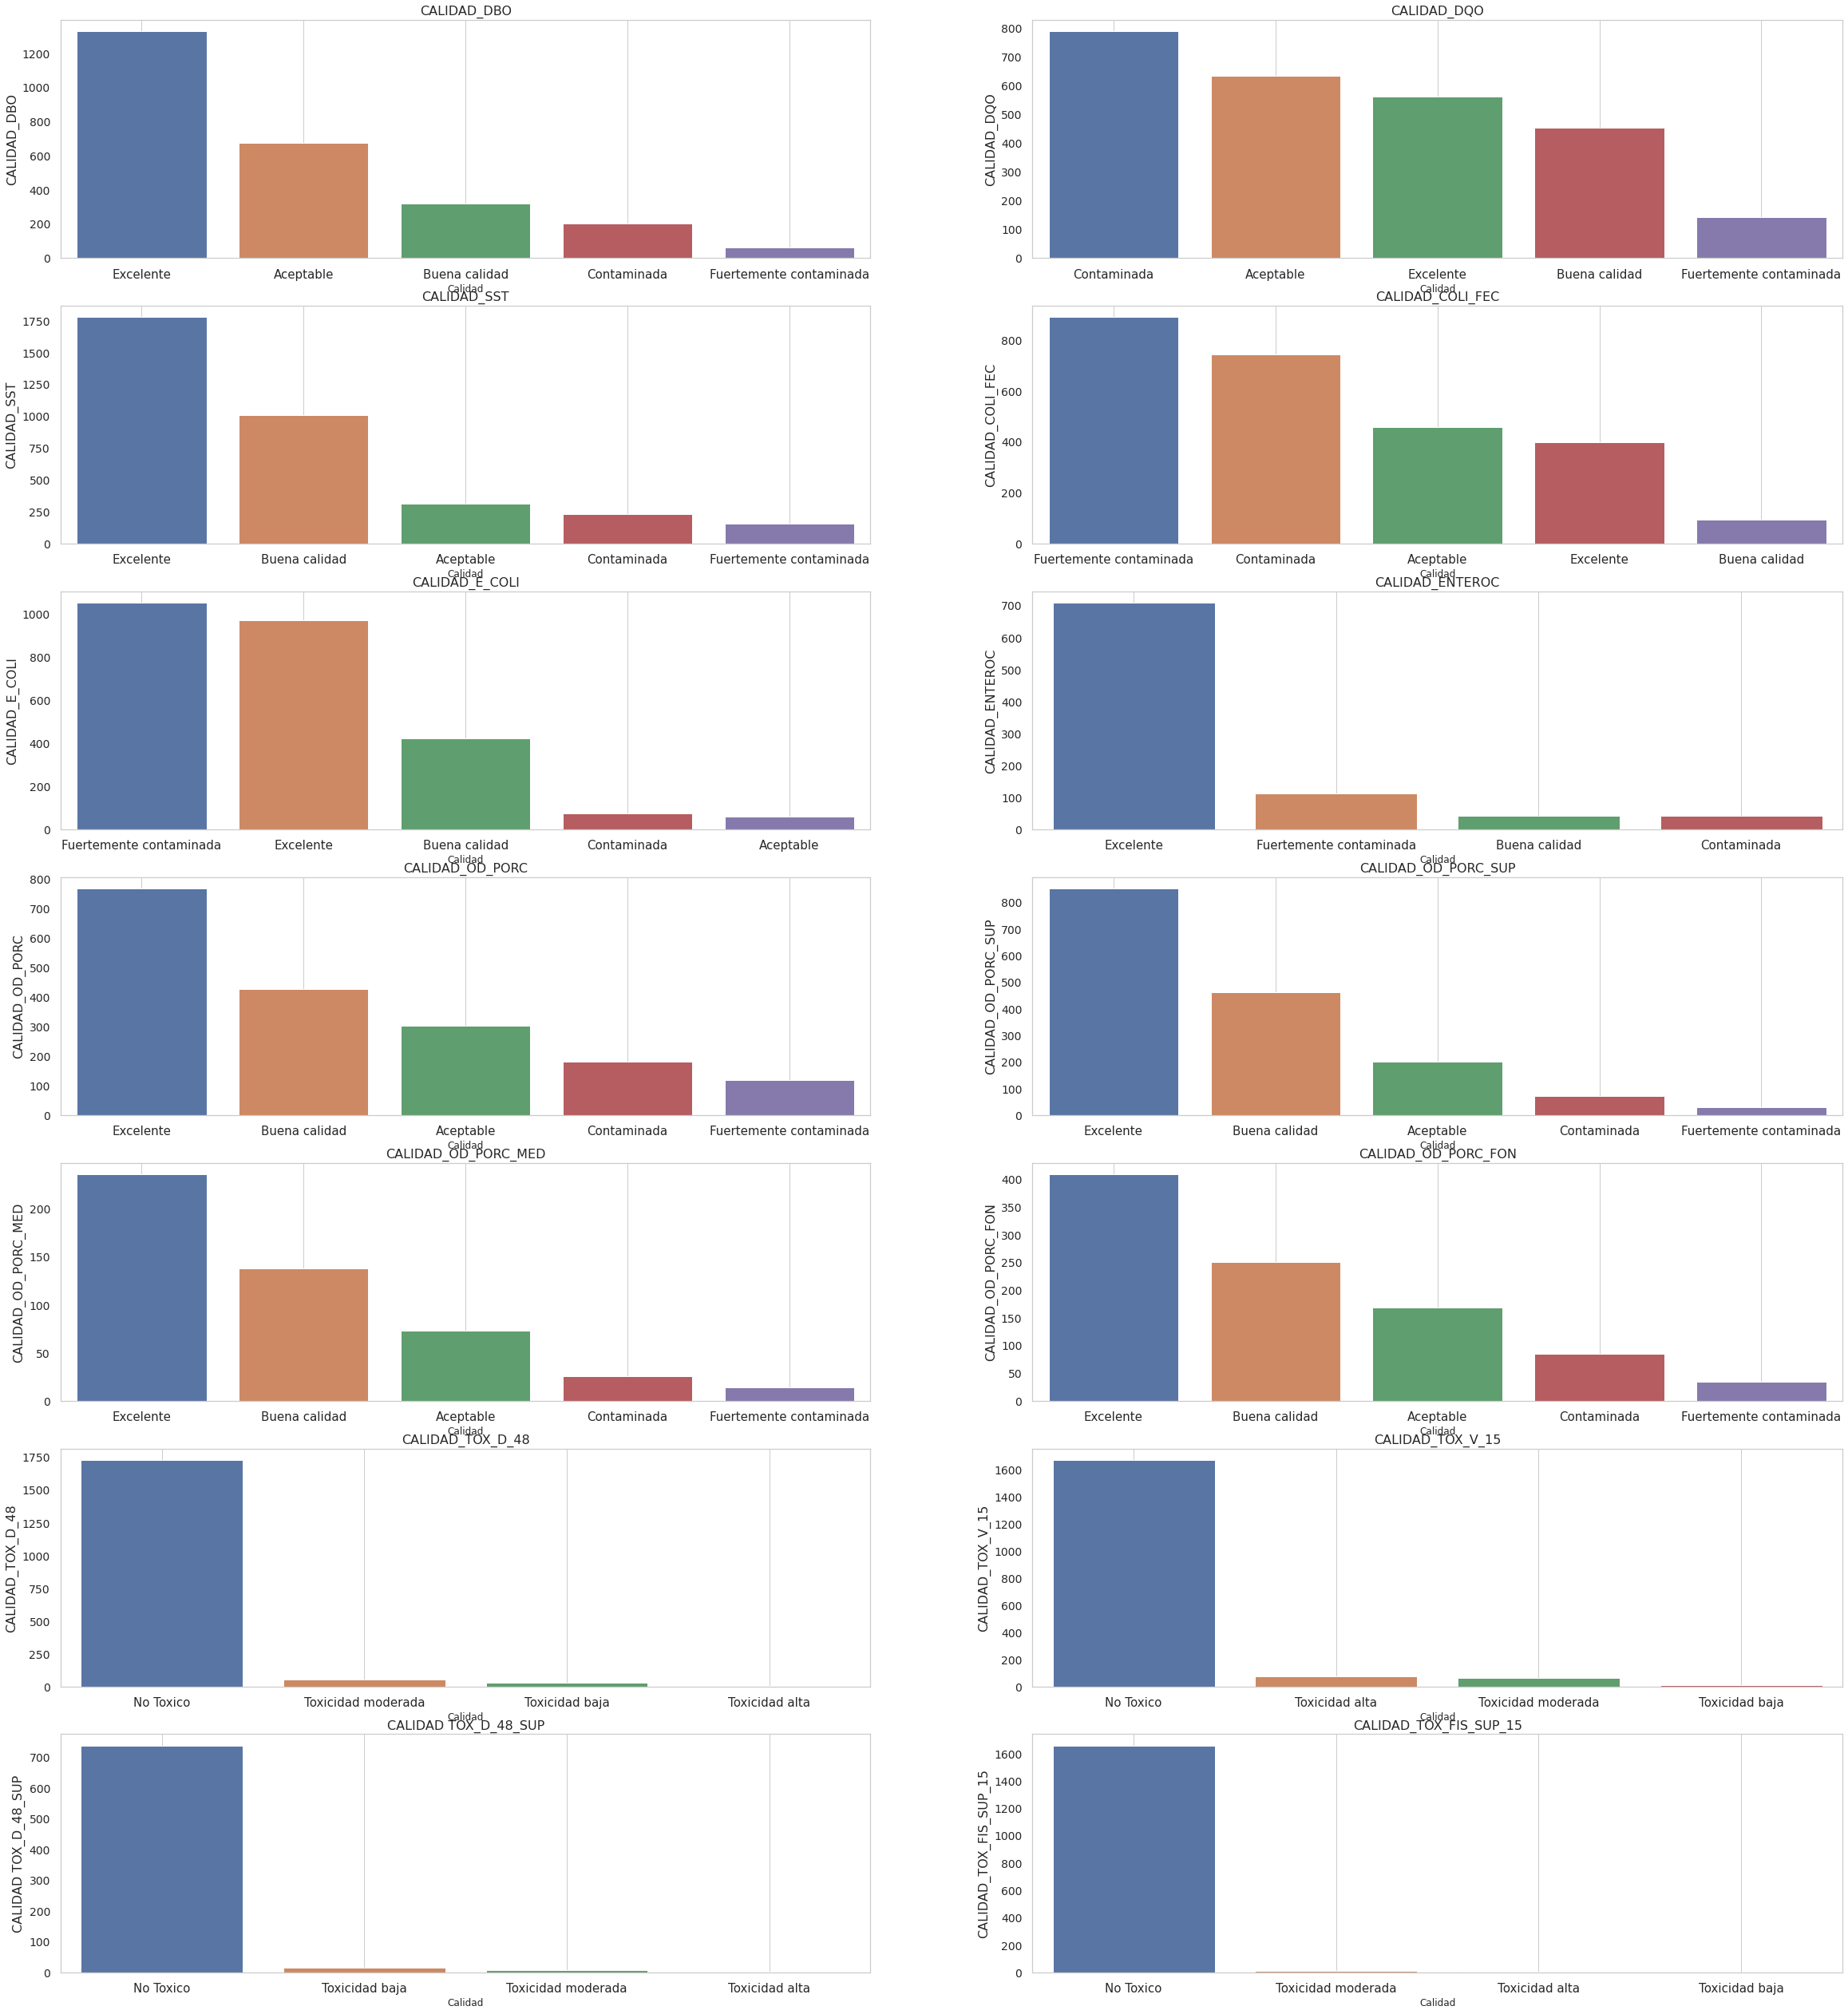

In [37]:
colunms_waterQA = [col for col in df_drop if col.startswith('CALIDAD')]
datos_plot = df_drop[colunms_waterQA].reset_index(drop=True)
# sns.set(rc={'figure.figsize':(40,45)})
fig, axs = plt.subplots(7,2, figsize=(40,45))

for k in range(len(colunms_waterQA)):
    
    plt.subplot(7,2, k+1)
    data_plot= pd.DataFrame(datos_plot[datos_plot.columns[k]].value_counts()).reset_index()
    data_plot.rename(columns={'index':'Calidad'}, inplace=True)
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=14)
    plt.ylabel(colunms_waterQA[k], fontsize=16)
    plt.title(colunms_waterQA[k], fontsize=16)
    sns.barplot(data=data_plot, x="Calidad", y=colunms_waterQA[k])
    plt.grid()

plt.show()

* Al revisar cada uno de los plots por calidad, observamos que no todas las calidades tiene la misma categorización. Por ejemplo, existen dos tipos dividos en varias categorizaciones. La primera da la categorización de calidad como: 
    * `Excelente`, `Buena Calidad`, `Aceptable`, `Contaminada`, `Fuertemente Contaminada`
    * `No Tóxico`, `Toxicidad moderada`, `Toxicidad baja`, `Toxicidad alta`
* Si pensamos en el balance de clases a la hora de poder predecir algún valor para datos nuevos, observamos que la variable `SEMAFORO` cuenta con un balanceo importante y no sería necesario buscar mecanimos de sobremuestreo para darle más peso a la clase minoritaria.

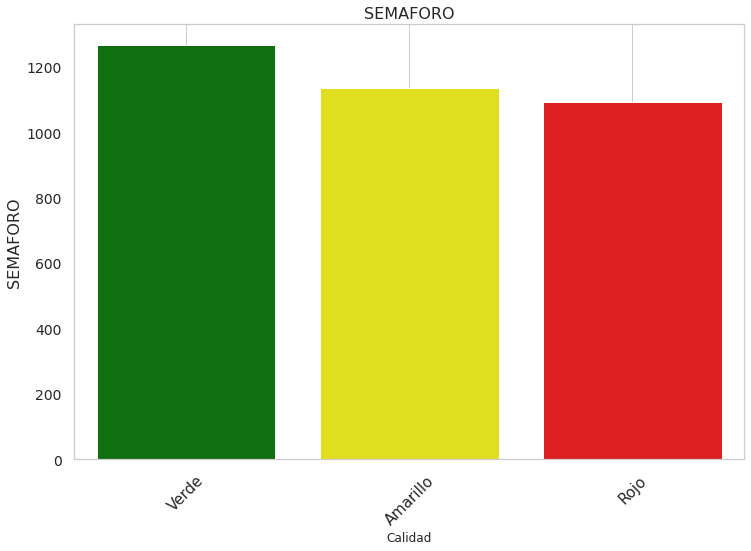

In [38]:
data_plot = pd.DataFrame(df_drop['SEMAFORO'].value_counts()).reset_index()
data_plot.rename(columns={'index':'Calidad'}, inplace=True)
fig, axs = plt.subplots(figsize=(12,8))
plt.xticks(fontsize=15, rotation=45)
plt.yticks(fontsize=14)
plt.ylabel('Calidad del agua', fontsize=16)
plt.title('SEMAFORO', fontsize=16)
sns.barplot(data=data_plot, x="Calidad", y="SEMAFORO", ax=axs, palette=['green', 'yellow', 'red'])
plt.grid()
plt.show()

### Agrupamiento del conteo de SEMAFORO y CALIDAD

Al realizar un agrupamiento por las variables `SEMAFORO` y cada una de las calidades para verificar su conteo, evidenciamos como mencionado al inicio que a pesar de algunas observaciones ser categorizada como `ROJO`o que no cumple los parámetros, para algunas calidad estas fueron categorizada como `Excelente`, `Aceptable` o de `Buena Calidad`. Con esto, tenemos que a nivel de negocio los imcumplimientos para tener la categorización del semáforo depende del peso que se le da a cada calidad específica y por ende esta distribución puede ser diferente para cada una de las observaciones de las variables `CALIDAD` y `SEMAFORO`.

In [39]:
def function_group(calidad = 'CALIDAD_SST'):

    df_group = pd.DataFrame(df_drop.groupby(['SEMAFORO', calidad]).size(), columns=['CONTEO'])
    return df_group

interact(function_group, calidad=colunms_waterQA)

interactive(children=(Dropdown(description='calidad', index=2, options=('CALIDAD_DBO', 'CALIDAD_DQO', 'CALIDAD…

<function __main__.function_group(calidad='CALIDAD_SST')>

### Visualización MAPA - CALIDAD - SEMAFORO

A continuación se observa una visualización interactiva donde se encuentra el mapa de `México` con los puntos latitud - longitud. Sin embargo, estos puntos son marcados con color blanco ya que el objetivo de la visualzación es poder marcar los colores del `SEMAFORO` para esta variable y la forma de cada punto sea representanda con la `CALIDAD`

In [40]:
def function_map(calidad='CALIDAD_SST'):
    
    sns.set_theme(style="whitegrid")

    df_gdf = df[['SITIO', 'ESTADO', 'ORGANISMO_DE_CUENCA', 'MUNICIPIO', 'CUENCA', 'CUERPO DE AGUA', 'LONGITUD', 'LATITUD', 'SEMAFORO', 'TIPO'] + colunms_waterQA]
    df_gdf = df_gdf.dropna(subset=[calidad])
    df_gdf[calidad + '_ENC'] = LabelEncoder().fit_transform(df_gdf[calidad])
    
    df_gdf["Coordinates"] = list(zip(df_gdf.LONGITUD, df_gdf.LATITUD))
    df_gdf["Coordinates"] = df_gdf["Coordinates"].apply(Point)
    gdf = gpd.GeoDataFrame(df_gdf, geometry="Coordinates")
    
    world = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))
    world = world.set_index("iso_a3")
    
    fig, gax = plt.subplots(figsize=(20,20))
    world.query("name == 'Mexico'").plot(ax = gax, edgecolor='black', color='white')
    gdf.plot(ax=gax, color='white', alpha = 0.5)
    color_dict = dict({'Rojo':'red', 'Verde':'green', 'Amarillo':'orange'})
    # sns.scatterplot(data=df_gdf, x="LONGITUD", y="LATITUD", hue="SEMAFORO", style=calidad, palette=['red', 'green', 'orange'])# palette="hls"
    sns.scatterplot(data=df_gdf, x="LONGITUD", y="LATITUD", hue='SEMAFORO', style=calidad, palette=color_dict)
    
    gax.set_xlabel('longitude', fontsize=14)
    gax.set_ylabel('latitude', fontsize=14)
    gax.set_title(calidad, fontsize=15)

    gax.spines['top'].set_visible(False)
    gax.spines['right'].set_visible(False)

    plt.show()

interact(function_map, calidad=colunms_waterQA)

interactive(children=(Dropdown(description='calidad', index=2, options=('CALIDAD_DBO', 'CALIDAD_DQO', 'CALIDAD…

<function __main__.function_map(calidad='CALIDAD_SST')>

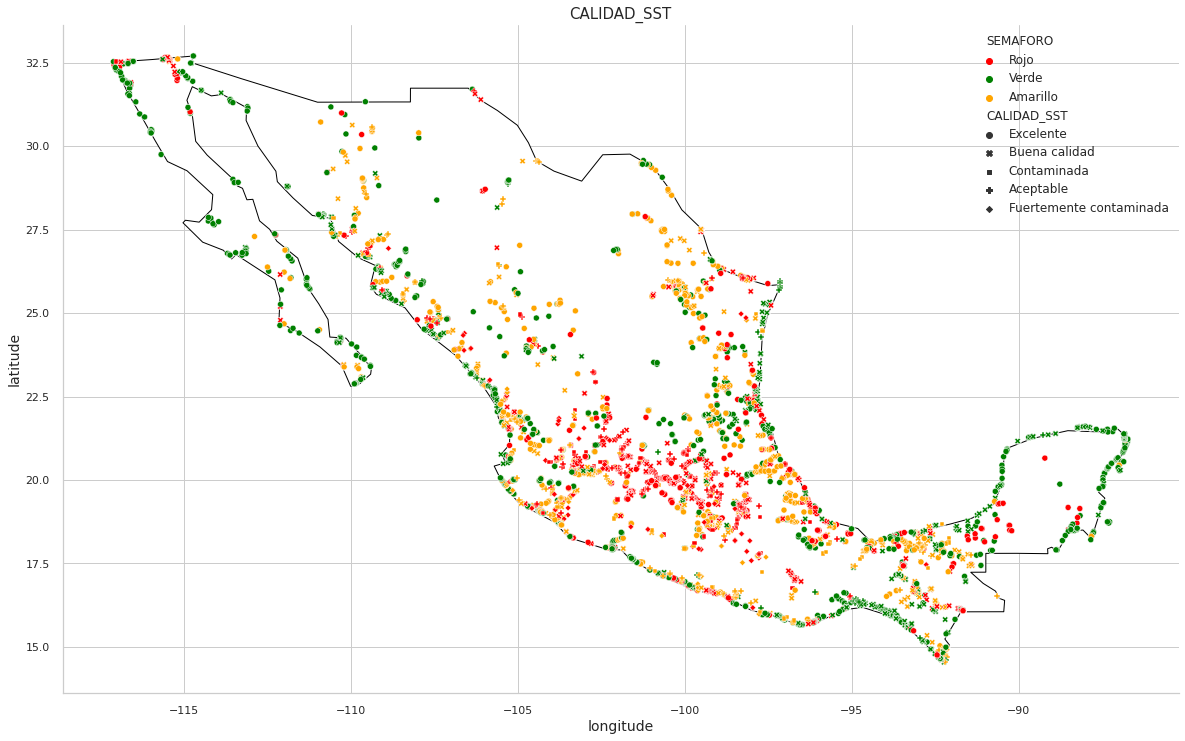

In [41]:
sns.set_theme(style="whitegrid")

df_gdf = df[['SITIO', 'ESTADO', 'ORGANISMO_DE_CUENCA', 'MUNICIPIO', 'CUENCA', 'CUERPO DE AGUA', 'LONGITUD', 'LATITUD', 'SEMAFORO', 'TIPO'] + ['CALIDAD_SST']]
df_gdf = df_gdf.dropna(subset=['CALIDAD_SST'])
df_gdf['CALIDAD_SST' + '_ENC'] = LabelEncoder().fit_transform(df_gdf['CALIDAD_SST'])
    
df_gdf["Coordinates"] = list(zip(df_gdf.LONGITUD, df_gdf.LATITUD))
df_gdf["Coordinates"] = df_gdf["Coordinates"].apply(Point)
gdf = gpd.GeoDataFrame(df_gdf, geometry="Coordinates")
    
world = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))
world = world.set_index("iso_a3")
    
fig, gax = plt.subplots(figsize=(20,20))
world.query("name == 'Mexico'").plot(ax = gax, edgecolor='black', color='white')
gdf.plot(ax=gax, color='white', alpha = 0.5)
color_dict = dict({'Rojo':'red', 'Verde':'green', 'Amarillo':'orange'})
    # sns.scatterplot(data=df_gdf, x="LONGITUD", y="LATITUD", hue="SEMAFORO", style=calidad, palette=['red', 'green', 'orange'])# palette="hls"
sns.scatterplot(data=df_gdf, x="LONGITUD", y="LATITUD", hue='SEMAFORO', style='CALIDAD_SST', palette=color_dict)
    
gax.set_xlabel('longitude', fontsize=14)
gax.set_ylabel('latitude', fontsize=14)
gax.set_title('CALIDAD_SST', fontsize=15)

gax.spines['top'].set_visible(False)
gax.spines['right'].set_visible(False)

plt.show()

* Como se observa en el mapa, en el centro de `México` se encuentran todos los puntos para la variable `SEMAFORO` categorizados como `ROJO`. Esto sucede para cada una de las calidades anteriormente mencionadas. En las costas cambia un poco el panomara ya que se hay muchos puntos `VERDES` donde cumple con los umbrales. Esto último es posible ya que las zonas mayormente contaminadas tienden a verse reflejadas hacía los centros de países debido a su industrialización. A medida que avanza la corriente de agua hacía el mar, estos tienden a dispersarse ya sea a las orillas de los afluentes o muchas veces a disolverse. 
* Un dato curioso que debe ser analizado más a nivel de negocio es poder ver la distribución de cuales `CALIDADES` si cumplen de alguna u otra manera con su umbral de aceptación, pero cuales no. Ya que por ejemplo, para el caso de `CALIDAD_SST` en el centro de `México` se tienen colores `ROJOS` para categorizaciones de esta `CALIDAD` como `EXCELENTE`. Esto se debe a la evaluación propia ponderada que se la da a cada una. Pero puede ser analizada para poder evidenciar que está sucediendo a nivel de contaminantes y poder atacar aquellos que a pesar de que unos cumplan, el `SEMAFORO` me indica un color `ROJO`.

## KMeans para las calidad y ubicaciones geoespaciales

CALIDAD_DBO


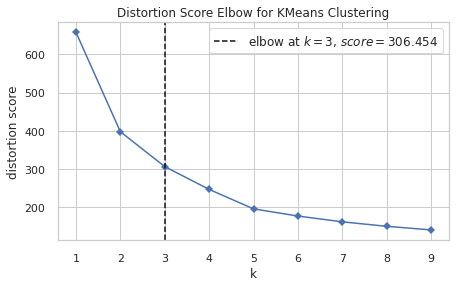

CALIDAD_DQO


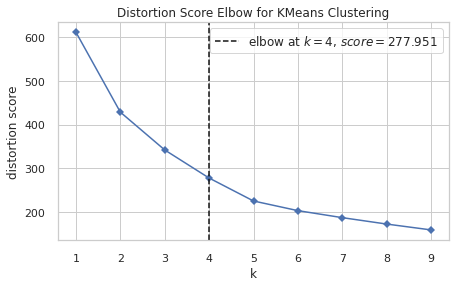

CALIDAD_SST


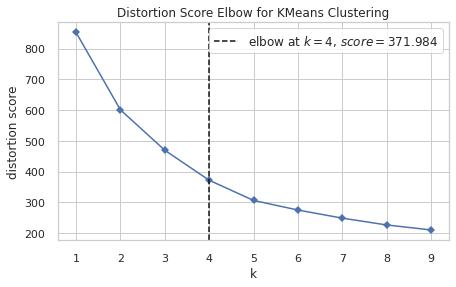

CALIDAD_COLI_FEC


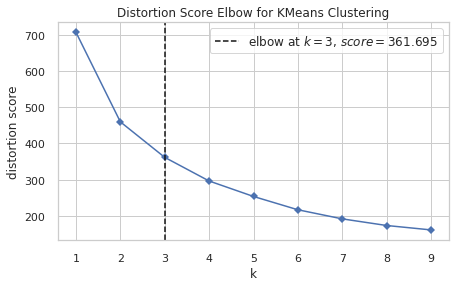

CALIDAD_E_COLI


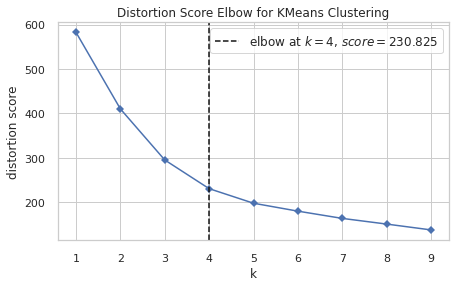

CALIDAD_ENTEROC


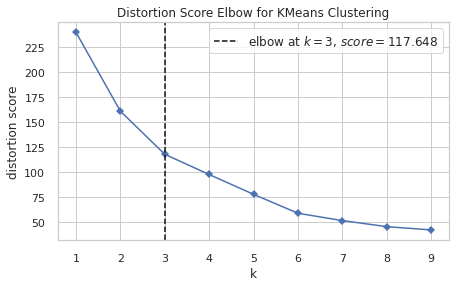

CALIDAD_OD_PORC


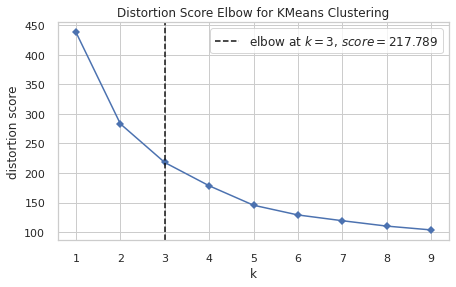

CALIDAD_OD_PORC_SUP


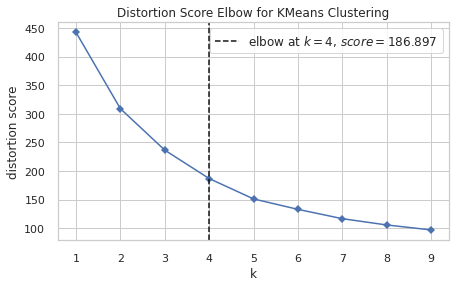

CALIDAD_OD_PORC_MED


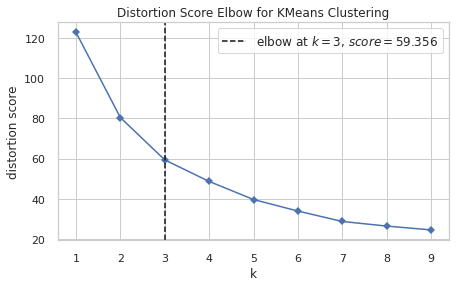

CALIDAD_OD_PORC_FON


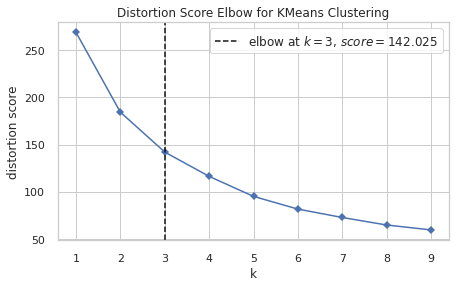

CALIDAD_TOX_D_48


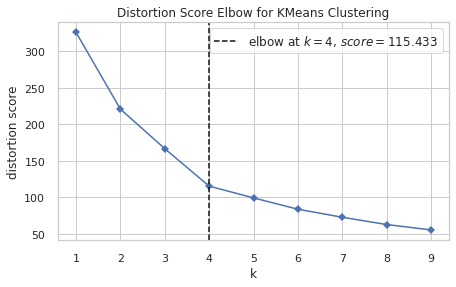

CALIDAD_TOX_V_15


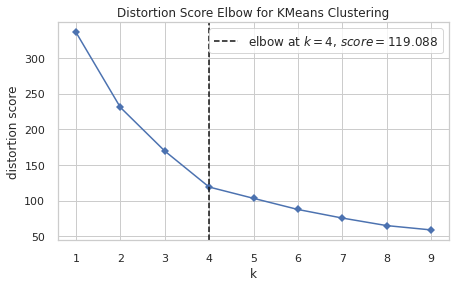

CALIDAD TOX_D_48_SUP


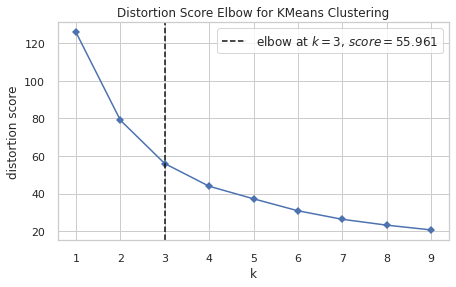

CALIDAD_TOX_FIS_SUP_15


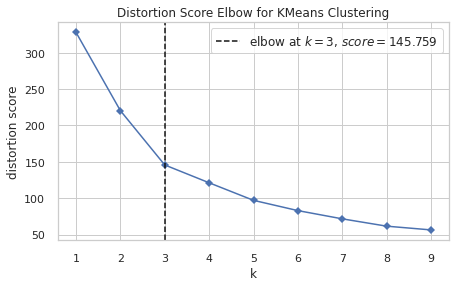

In [42]:
dict_values = {}
for k in range(len(colunms_waterQA)):

    fig, axs = plt.subplots(figsize=(7,4))
    df_gdf = df[['LONGITUD', 'LATITUD', 'CUENCA' ,'SEMAFORO', colunms_waterQA[k]]]
    df_gdf = df_gdf.dropna(subset=[colunms_waterQA[k]]).reset_index(drop=True)
    # df_gdf[colunms_waterQA[k] + '_ENC'] = LabelEncoder().fit_transform(df_gdf[colunms_waterQA[k]])
    # df_gdf['SEMAFORO_ENC'] = LabelEncoder().fit_transform(df_gdf['SEMAFORO'])
    # df_gdf['CUENCA_ENC'] = LabelEncoder().fit_transform(df_gdf['CUENCA'])
    df_gdf[colunms_waterQA[k] + '_ENC'] = OrdinalEncoder().fit_transform(df_gdf[[colunms_waterQA[k]]])
    df_gdf['SEMAFORO_ENC'] = OrdinalEncoder().fit_transform(df_gdf[['SEMAFORO']])
    df_gdf['CUENCA_ENC'] = OrdinalEncoder().fit_transform(df_gdf[['CUENCA']])
    df_gdf = df_gdf.dropna(subset=['CUENCA_ENC']).reset_index(drop=True)
      
    df_gdf["Coordinates"] = list(zip(df_gdf.LONGITUD, df_gdf.LATITUD))
    df_gdf["Coordinates"] = df_gdf["Coordinates"].apply(Point)
    gdf = gpd.GeoDataFrame(df_gdf, geometry="Coordinates")
    X_cluster = gdf[[colunms_waterQA[k] + '_ENC',  'LONGITUD', 'LATITUD', 'CUENCA_ENC']]# 'SEMAFORO_ENC'
    X_cluster_scal = MinMaxScaler(feature_range=(1,2)).fit_transform(X_cluster)

    print(colunms_waterQA[k])
    vzr = KElbowVisualizer(KMeans(random_state=42), k=(1, 10), timings=False, ax=axs)
    value = vzr.fit(X_cluster_scal)
    vzr.poof()
    dict_values[colunms_waterQA[k]] = value.elbow_value_

* Como se observa usando las variables mencionadas, los mejores cluster para cada una de las calidades varía entre 3 y 4 grupos. Estos serán guardados y usados para el clustering de visualización
* La librería `yellowbricks` es una herramienta útil para seleccionar estos grupos y poder segmentar las calidades en el mapa de `México`

## Mostrar resultados de agrupamiento de latitudes y longitudes con K means en el mapa de México..

In [43]:
def function_map(calidad='CALIDAD_SST'):
    
    sns.set_theme(style="whitegrid")

    df_gdf = df[['LONGITUD', 'LATITUD', 'CUENCA','SEMAFORO', calidad]]
    df_gdf = df_gdf.dropna(subset=[calidad]).reset_index(drop=True)
    df_gdf[calidad + '_ENC'] = OrdinalEncoder().fit_transform(df_gdf[[calidad]])
    df_gdf['SEMAFORO_ENC'] = OrdinalEncoder().fit_transform(df_gdf[['SEMAFORO']])
    df_gdf['CUENCA_ENC'] = OrdinalEncoder().fit_transform(df_gdf[['CUENCA']])
    df_gdf = df_gdf.dropna(subset=['CUENCA_ENC']).reset_index(drop=True)
        
    df_gdf["Coordinates"] = list(zip(df_gdf.LONGITUD, df_gdf.LATITUD))
    df_gdf["Coordinates"] = df_gdf["Coordinates"].apply(Point)
    gdf = gpd.GeoDataFrame(df_gdf, geometry="Coordinates")
        
    X_cluster = gdf[[calidad + '_ENC',  'LONGITUD', 'LATITUD', 'CUENCA_ENC']]# 'SEMAFORO_ENC'
    X_cluster_scal = MinMaxScaler(feature_range=(1,2)).fit_transform(X_cluster)
    kmeans = KMeans(n_clusters=dict_values[calidad], random_state=42)
    kmeans.fit(X_cluster_scal)
    y_kmeans = kmeans.predict(X_cluster_scal)
    df_gdf = pd.concat([df_gdf, pd.Series(y_kmeans, name='cluster')], axis=1)
        
    world = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))
    world = world.set_index("iso_a3")
        
    fig, gax = plt.subplots(figsize=(20,20))
    world.query("name == 'Mexico'").plot(ax = gax, edgecolor='black', color='white')
    gdf.plot(ax=gax, color='white', alpha = 0.5)
    color_dict = dict({'Rojo':'red', 'Verde':'green', 'Amarillo':'orange'})
    sns.scatterplot(data=df_gdf, x="LONGITUD", y="LATITUD", hue='SEMAFORO', style='cluster', palette=color_dict)
        
    gax.set_xlabel('longitude', fontsize=14)
    gax.set_ylabel('latitude', fontsize=14)
    gax.set_title(calidad, fontsize=15)

    gax.spines['top'].set_visible(False)
    gax.spines['right'].set_visible(False)

    plt.show()

interact(function_map, calidad=colunms_waterQA)

interactive(children=(Dropdown(description='calidad', index=2, options=('CALIDAD_DBO', 'CALIDAD_DQO', 'CALIDAD…

<function __main__.function_map(calidad='CALIDAD_SST')>

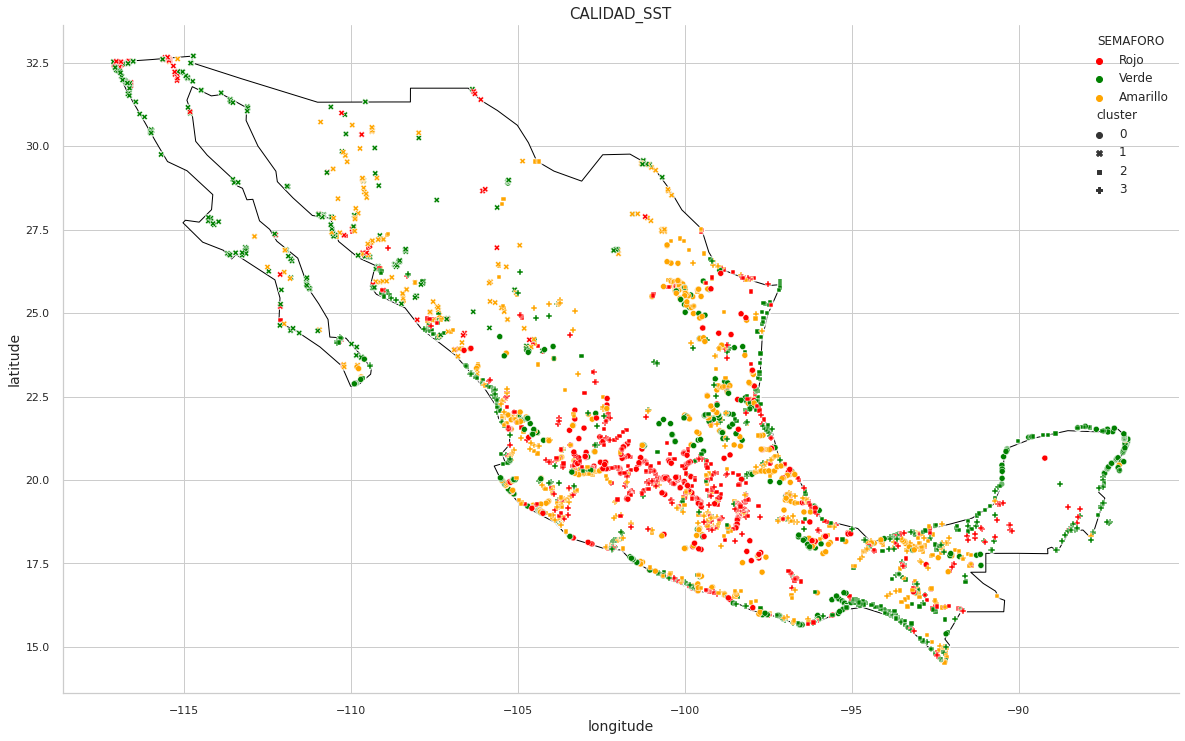

In [44]:
sns.set_theme(style="whitegrid")

df_gdf = df[['LONGITUD', 'LATITUD', 'CUENCA','SEMAFORO', 'CALIDAD_SST']]
df_gdf = df_gdf.dropna(subset=['CALIDAD_SST']).reset_index(drop=True)
df_gdf['CALIDAD_SST' + '_ENC'] = OrdinalEncoder().fit_transform(df_gdf[['CALIDAD_SST']])
df_gdf['SEMAFORO_ENC'] = OrdinalEncoder().fit_transform(df_gdf[['SEMAFORO']])
df_gdf['CUENCA_ENC'] = OrdinalEncoder().fit_transform(df_gdf[['CUENCA']])
df_gdf = df_gdf.dropna(subset=['CUENCA_ENC']).reset_index(drop=True)
        
df_gdf["Coordinates"] = list(zip(df_gdf.LONGITUD, df_gdf.LATITUD))
df_gdf["Coordinates"] = df_gdf["Coordinates"].apply(Point)
gdf = gpd.GeoDataFrame(df_gdf, geometry="Coordinates")
        
X_cluster = gdf[['CALIDAD_SST' + '_ENC',  'LONGITUD', 'LATITUD', 'CUENCA_ENC']]# 'SEMAFORO_ENC'
X_cluster_scal = MinMaxScaler(feature_range=(1,2)).fit_transform(X_cluster)
kmeans = KMeans(n_clusters=dict_values['CALIDAD_SST'], random_state=42)
kmeans.fit(X_cluster_scal)
y_kmeans = kmeans.predict(X_cluster_scal)
df_gdf = pd.concat([df_gdf, pd.Series(y_kmeans, name='cluster')], axis=1)
        
world = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))
world = world.set_index("iso_a3")
        
fig, gax = plt.subplots(figsize=(20,20))
world.query("name == 'Mexico'").plot(ax = gax, edgecolor='black', color='white')
gdf.plot(ax=gax, color='white', alpha = 0.5)
color_dict = dict({'Rojo':'red', 'Verde':'green', 'Amarillo':'orange'})
sns.scatterplot(data=df_gdf, x="LONGITUD", y="LATITUD", hue='SEMAFORO', style='cluster', palette=color_dict)
        
gax.set_xlabel('longitude', fontsize=14)
gax.set_ylabel('latitude', fontsize=14)
gax.set_title('CALIDAD_SST', fontsize=15)

gax.spines['top'].set_visible(False)
gax.spines['right'].set_visible(False)

plt.show()

## Conclusiones

* Con las variabes mencionadas y usadas para la segmentación, se observa en el gráfico interactivo diferentes comportamiento pero coindicen en los mismos observados en el primero gráfico interactivo. La mayoría de los puntos rojos coinciden en el centro de México y la mayoría de los puntos verdes están en las costas.
* Para la calidad escogida muestra que existen evaluación (categorizaciones de calidad) y cuencas que pueden tener una relación. Ya que ejemplo, los puntos críticos marcados como rojos en el centro que pertenecen a diferentes cuencas y evaluaciones. Por ejemplo, hay punto que pertenecen al cluster 0, otros al 2 y otros al 3. Hacía el norte existen cluster y puntos que coinciden. La relación sigue existiendo entre cuencas y esto como mencionado, nos da una mayor idea de ver la contaminación de las aguas no solo por latitud y longitud, también por cuenca y calidades.
* Si observamos el mapa, se ve que también existen puntos verdes de `SEMAFORO` que pertenecen al cluster 0 donde hay puntos rojos. Las cuencas guardan una relación tan fuerte en contaminaciones pero también debe ser considerado la región ya que mucha veces cuando el afluente antes de llegar a la ciudad es limpio y en una ciudad poblada cambia esta situación.